In [1]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

Here we are using a Reddit API wrapper, called `praw`, to loop through the /r/politics subreddit headlines.

In [2]:
import praw

In [3]:
reddit = praw.Reddit(client_id='I63tI5BvF7PVjkebaeTJxg',
                     client_secret='wLDZSQMRWwko3Hdi3FJkJTi229GPlA',
                     user_agent='AnjaniJeegni')

In [4]:
headlines = set()
#a set for our headlines so we don't get duplicates when running multiple times

In [5]:
#we iterating through the /r/politics subreddit using the API client
for submission in reddit.subreddit('politics').new(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

961


We're iterating over the new posts in /r/politics, and by adding the limit to None we can get up to 1000 headlines. 

This time we only received 961 headlines.

Without some more advanced tricks we can't go past 1000 results since Reddit cuts off at that point. We can run this loop multiple times and keep adding new headlines to our set, or we can implement a streaming version.

## Labeling our Data

NLTK’s built-in Vader Sentiment Analyzer will give rank a piece of text as positive, negative or neutral using a lexicon of positive and negative words.

We can utilize this tool by first creating a Sentiment Intensity Analyzer- SIA to categorize our headlines, then we'll use the polarity_scores method to get the sentiment.

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.6369,
  'headline': 'Get rid of tariffs on China to help ease inflation, two dozen business groups tell '
              'Biden',
  'neg': 0.0,
  'neu': 0.729,
  'pos': 0.271},
 {'compound': -0.0772,
  'headline': 'Even in Solidly Blue States, Democrats Aren’t Pursuing Serious Progressive Change',
  'neg': 0.115,
  'neu': 0.885,
  'pos': 0.0},
 {'compound': -0.7269,
  'headline': 'U.S. senator introduces bill to block Brazilian beef imports after "mad cow" '
              'reports',
  'neg': 0.357,
  'neu': 0.643,
  'pos': 0.0}]


In [7]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headline
0,0.000,0.729,0.271,0.6369,Get rid of tariffs on China to help ease infla...
1,0.115,0.885,0.000,-0.0772,"Even in Solidly Blue States, Democrats Aren’t ..."
2,0.357,0.643,0.000,-0.7269,U.S. senator introduces bill to block Brazilia...
3,0.000,1.000,0.000,0.0000,Sen. Ossoff working to pass bill to fund Cyber...
4,0.178,0.822,0.000,-0.3818,Progressives Slam GOP's 'Shameful' Attempt to ...


The above table consists of four columns from the sentiment scoring: Neural, Negative, Positive and compound. 
The first three represent the sentiment score percentage of each category in our headline, and the compound single number that scores the sentiment.

In [8]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

# We are creating a positive label of 1 if the compound is greater than 0.2, and a label of -1 if compound is less than -0.2. Everything else will be 0.

,neg,neu,pos,compound,headline,label
0,0.000,0.729,0.271,0.6369,Get rid of tariffs on China to help ease infla...,1
1,0.115,0.885,0.000,-0.0772,"Even in Solidly Blue States, Democrats Aren’t ...",0
2,0.357,0.643,0.000,-0.7269,U.S. senator introduces bill to block Brazilia...,-1
3,0.000,1.000,0.000,0.0000,Sen. Ossoff working to pass bill to fund Cyber...,0
4,0.178,0.822,0.000,-0.3818,Progressives Slam GOP's 'Shameful' Attempt to ...,-1


In [9]:
df2 = df[['headline', 'label']]
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

# Dataset Info and Statistics

In [10]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['Get rid of tariffs on China to help ease inflation, two dozen business groups tell Biden',
 "[Politics] - Week in politics: The 'Build Back Better' bill is moving forward | NPR",
 'Discussion Thread: House of Representatives votes on the Build Back Better reconciliation bill',
 'With Back Channels to Manchin and Sinema, Pelosi Found a Path to a Deal: The House’s approval of a sweeping social policy bill after weeks of fits and starts notched another win for the speaker in '
 'a career defined by them.',
 'Biden Sells Infrastructure Improvements as a Way to Counter China']

Negative headlines:

['U.S. senator introduces bill to block Brazilian beef imports after "mad cow" reports',
 "Progressives Slam GOP's 'Shameful' Attempt to Add Another $25 Billion to Pentagon Budget",
 'Why are Americans so unhappy with Joe Biden? | Robert Reich',
 'House Vote On Biden Spending Bill Is Delayed By Kevin McCarthy Talking For Hours',
 'Lauren Boebert accuses Black Congresswoman 

In [11]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 0    403
-1    330
 1    228
Name: label, dtype: int64
 0    41.935484
-1    34.339230
 1    23.725286
Name: label, dtype: float64


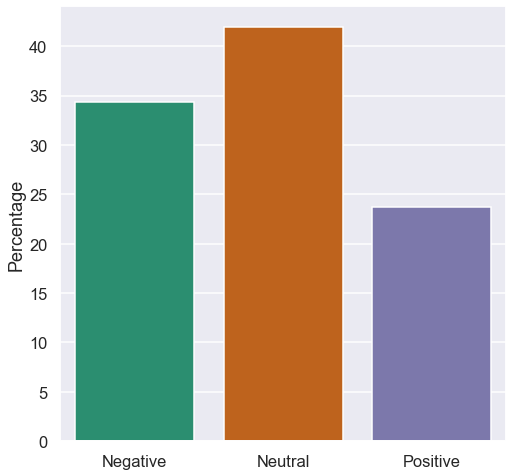

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [13]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

example = "This is an example sentence! However, it isn't a very informative one"

print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


In [14]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 'However',
 'it',
 'isn',
 't',
 'a',
 'very',
 'informative',
 'one']

In [15]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


# Now, we will send the CSV file of our scraped data to Azure blob storage